## Train an Supervised XGBoost model using the data stored in feature store

In [2]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

#### we will use the feature group created during feature store lab

In [ ]:
%store -r

In [3]:
from sagemaker.feature_store.feature_group import FeatureGroup

fd_feature_group_name = fd_feature_group_name

fd_feature_group = FeatureGroup(name=fd_feature_group_name, sagemaker_session=feature_store_session)

## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [4]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-demo'

print(default_s3_bucket_name)

sagemaker-us-east-1-365792799466


In [5]:
transaction_query = fd_feature_group.athena_query()

transaction_table = transaction_query.table_name

print(transaction_table)

query_string = 'SELECT * FROM "'+transaction_table+'"'
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
transaction_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
transaction_query.wait()
dataset = transaction_query.as_dataframe()

dataset

transactionfeaturegroup001-1629730459
Running SELECT * FROM "transactionfeaturegroup001-1629730459"


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v26,v27,v28,amount,class,event_time,record_id,write_time,api_invocation_time,is_deleted
0,71501.0,-1.118315,0.656022,1.311607,-0.291451,-0.546622,-1.078459,0.294874,0.326937,0.034244,...,-0.998707,-0.000190,0.170155,62.74,0.0,1.629730e+09,109706,2021-08-23 15:02:54.465,2021-08-23 14:57:30.000,False
1,36.0,-1.169422,1.158314,1.406800,0.860189,-0.103810,0.122035,0.264451,-0.108767,-0.181977,...,0.226700,-0.810101,0.234957,7.99,0.0,1.629730e+09,53,2021-08-23 15:02:54.465,2021-08-23 14:57:30.000,False
2,67.0,-0.653445,0.160225,1.592256,1.296832,0.997175,-0.343000,0.469937,-0.132470,-0.197794,...,-0.348637,0.011238,-0.049478,19.85,0.0,1.629730e+09,98,2021-08-23 15:02:54.465,2021-08-23 14:57:31.000,False
3,71544.0,-0.385981,0.758631,1.399149,0.824479,0.138338,-0.000999,0.832129,0.068134,-0.241392,...,-0.353056,0.048941,0.023557,49.19,0.0,1.629730e+09,109801,2021-08-23 15:02:54.465,2021-08-23 14:57:31.000,False
4,71549.0,1.130942,-0.932415,0.111734,-0.653126,-1.010384,-0.476458,-0.397194,-0.111684,-1.077497,...,1.105381,-0.084372,0.015294,135.00,0.0,1.629730e+09,109811,2021-08-23 15:02:54.465,2021-08-23 14:57:31.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164529,66446.0,-1.346030,1.326632,1.257581,1.074451,0.156222,0.695528,0.190739,0.629163,-0.394167,...,-0.247330,0.360396,0.127730,36.00,0.0,1.629730e+09,97934,2021-08-23 15:07:24.144,2021-08-23 15:07:21.000,False
164530,41536.0,-2.385380,2.399992,-0.265523,-0.454264,-0.016643,1.033515,-1.321362,-1.250268,-1.844194,...,-0.039001,-0.637531,-0.142065,22.00,0.0,1.629730e+09,43515,2021-08-23 15:07:24.144,2021-08-23 15:07:22.000,False
164531,66473.0,-1.565561,1.549571,0.761251,-1.500812,-0.004349,0.250275,-0.958032,-2.090346,-0.481178,...,0.908449,0.030681,0.072758,0.54,0.0,1.629730e+09,97994,2021-08-23 15:07:24.144,2021-08-23 15:07:22.000,False
164532,66476.0,-4.305401,2.990352,-0.106128,-0.227977,-1.293100,-0.422289,-0.245509,0.500373,1.749776,...,0.086189,-1.519313,0.552498,13.54,0.0,1.629730e+09,98000,2021-08-23 15:07:24.144,2021-08-23 15:07:22.000,False


In [6]:
# Select useful columns for training with target column as the first.
dataset = dataset[['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class']]


In [7]:
dataset = dataset.dropna()
dataset.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,71501.0,-1.118315,0.656022,1.311607,-0.291451,-0.546622,-1.078459,0.294874,0.326937,0.034244,...,0.299079,0.601609,0.233180,0.681757,-1.034985,-0.998707,-0.000190,0.170155,62.74,0.0
1,36.0,-1.169422,1.158314,1.406800,0.860189,-0.103810,0.122035,0.264451,-0.108767,-0.181977,...,0.024498,-0.120153,0.212986,0.087536,-0.946530,0.226700,-0.810101,0.234957,7.99,0.0
2,67.0,-0.653445,0.160225,1.592256,1.296832,0.997175,-0.343000,0.469937,-0.132470,-0.197794,...,0.038363,0.336449,-0.014883,0.102959,-0.265322,-0.348637,0.011238,-0.049478,19.85,0.0
3,71544.0,-0.385981,0.758631,1.399149,0.824479,0.138338,-0.000999,0.832129,0.068134,-0.241392,...,-0.008999,0.086109,-0.096526,0.074640,0.235852,-0.353056,0.048941,0.023557,49.19,0.0
4,71549.0,1.130942,-0.932415,0.111734,-0.653126,-1.010384,-0.476458,-0.397194,-0.111684,-1.077497,...,-0.191199,-0.361440,-0.157841,0.060984,0.260320,1.105381,-0.084372,0.015294,135.00,0.0


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [8]:
nonfrauds, frauds = dataset.groupby('class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  358
Number of non-frauds:  164175
Percentage of fradulent data: 0.21758552995447722


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here:. 

Tip: For our dataset this amount of preprocessing will give us reasonable accuracy, but it's important to note that there are more preprocessing steps one can use to improve accuracy . For unbalanced data sets like ours where the positive (fraudulent) examples occur much less frequently than the negative (legitimate) examples, we may try “over-sampling” the minority dataset by generating synthetic data (read about SMOTE in Data Mining for Imbalanced Datasets: An Overview (https://link.springer.com/chapter/10.1007%2F0-387-25465-X_40) or undersampling the majority class by using ensemble methods (see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdfor).

In [9]:
feature_columns = dataset.columns[:-1]
label_column = dataset.columns[-1]

features = dataset[feature_columns].values.astype('float32')
labels = (dataset[label_column].values).astype('float32')

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

## Amazon SageMaker XGBoost


### Prepare Data and Upload to S3

In [15]:
import io
import sklearn
import os
from sklearn.datasets import dump_svmlight_file   

buf = io.BytesIO()

sklearn.datasets.dump_svmlight_file(X_train, y_train, buf)
buf.seek(0);


In [16]:
key = 'fraud-dataset'
subdir = 'base'
boto3.resource('s3', region_name=region).Bucket(default_s3_bucket_name).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}/{}'.format(default_s3_bucket_name, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(default_s3_bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/train/base/fraud-dataset
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/output


---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.
To specify the Linear Learner algorithm, we use a utility function to obtain it's URI. A complete list of build-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [17]:
import sagemaker
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

SageMaker abstracts training with Estimators. We can pass container, and all parameters to the estimator, as well as the hyperparameters for the linear learner and fit the estimator to the data in S3.
Note: For IP protection reasons, SageMaker built-in algorithms, such as XGBoost, can't be run locally, i.e. on the same instance where this Jupyter Notebook code is running. 

In [18]:
sagemaker_iam_role = sagemaker.get_execution_role()
session = sagemaker.Session()


In [19]:
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
xgb.set_hyperparameters(max_depth=5,
                        eval_metric='auc',
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [20]:
xgb.fit({'train': s3_train_data}) 

2021-11-25 04:53:12 Starting - Starting the training job...
2021-11-25 04:53:19 Starting - Launching requested ML instancesProfilerReport-1637815992: InProgress
......
2021-11-25 04:54:26 Starting - Preparing the instances for training............
2021-11-25 04:56:43 Downloading - Downloading input data
2021-11-25 04:56:43 Training - Downloading the training image...Arguments: train
[2021-11-25:04:57:05:INFO] Running standalone xgboost training.
[2021-11-25:04:57:05:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-11-25:04:57:05:INFO] File size need to be processed in the node: 90.89mb. Available memory size in the node: 8334.96mb
[04:57:05] S3DistributionType set as FullyReplicated
[04:57:06] 148079x30 matrix with 4441392 entries loaded from /opt/ml/input/data/train
[04:57:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=4
[0]#011train-auc:0.932835
[04:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14

### Host XGBoost Model


Now we deploy the estimator to and endpoint.

In [21]:
from sagemaker.predictor import CSVDeserializer,CSVSerializer

predictor = xgb.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format("fraud-detection"),
                       endpoint_name="{}-xgb".format("fraud-detection"),
                       instance_type="ml.c5.xlarge",
                       serializer=CSVSerializer(),
                       deserializer=None)

Using already existing model: fraud-detection-xgb


----!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, 
simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [24]:
# Because we have a large test set, we call predict on smaller batches
import numpy as np

def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [25]:
raw_preds = predict(predictor, X_test)

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

Two such metrics are the [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score), and [Cohen's Kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa).

In [26]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# scikit-learn expects 0/1 predictions, so we threshold our raw predictions
y_preds = np.where(raw_preds > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, y_preds)))

Balanced accuracy = 0.9458545772427724
Cohen's Kappa = 0.9038964419872538


We can already see that our model performs very well in terms of both metrics, Cohen's Kappa scores above 0.8 are generally very favorable.

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

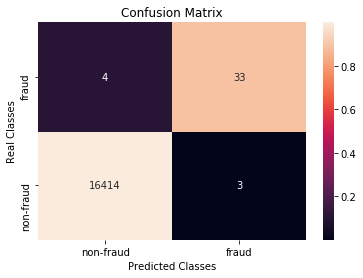

In [28]:
plot_confusion_matrix(y_test, y_preds)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     16417
       fraud       0.92      0.89      0.90        37

    accuracy                           1.00     16454
   macro avg       0.96      0.95      0.95     16454
weighted avg       1.00      1.00      1.00     16454



### SMOTE

Now that we have a baseline model using XGBoost, we can try to see if sampling techniques that are designed specifically for imbalanced problems can improve the performance of the model.

For that purpose we will be using the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) package that works well with scikit-learn. 

We will be using [Sythetic Minority Over-sampling](https://arxiv.org/abs/1106.1813) (SMOTE), which oversamples the minority class by interpolating new data points between existing ones.

In [30]:
!pip install imbalanced-learn==0.6.0
!pip install scikit-learn==0.22.1


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 162 kB 26.1 MB/s            
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

We can see that SMOTE has now balanced the two classes:

In [32]:
from collections import Counter
print(sorted(Counter(y_smote).items()))

[(0.0, 147758), (1.0, 147758)]


We note that this is a case of extreme oversampling of the the minority class, we went from ~0.17% to 50%. An alternative would be to use a smaller resampling ratio, such as having one minority cl
ass sample for every `sqrt(non_fraud/fraud)` majority samples, or using more advanced resampling techniques. See the [comparison](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py) provided by imbalanced-learn for more over-sampling options.

In our case we'll use the SMOTE dataset we just created and upload it to S3 for training.

In [35]:
smote_buf = io.BytesIO()

# Dump the SMOTE data into a buffer
sklearn.datasets.dump_svmlight_file(X_smote, y_smote, smote_buf)
smote_buf.seek(0);

# Upload from the buffer to S3
key = 'fraud-dataset-smote'
subdir = 'smote'
boto3.resource('s3', region_name=region).Bucket(default_s3_bucket_name).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(smote_buf)

s3_smote_train_data = 's3://{}/{}/train/{}/{}'.format(default_s3_bucket_name, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_smote_train_data))

smote_output_location = 's3://{}/{}/smote-output'.format(default_s3_bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(smote_output_location))

Uploaded training data location: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/train/smote/fraud-dataset-smote
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/smote-output


In [36]:
smote_xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
smote_xgb.set_hyperparameters(max_depth=5,
                        eval_metric='auc',
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [37]:
smote_xgb.fit({'train': s3_smote_train_data})

2021-11-25 05:51:27 Starting - Starting the training job...
2021-11-25 05:51:50 Starting - Launching requested ML instancesProfilerReport-1637819487: InProgress
......
2021-11-25 05:52:50 Starting - Preparing the instances for training............
2021-11-25 05:54:51 Downloading - Downloading input data...
2021-11-25 05:55:20 Training - Downloading the training image...
2021-11-25 05:55:55 Training - Training image download completed. Training in progress..Arguments: train
[2021-11-25:05:55:57:INFO] Running standalone xgboost training.
[2021-11-25:05:55:57:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-11-25:05:55:57:INFO] File size need to be processed in the node: 181.1mb. Available memory size in the node: 8340.85mb
[05:55:57] S3DistributionType set as FullyReplicated
[05:55:58] 295516x30 matrix with 8864018 entries loaded from /opt/ml/input/data/train
[05:55:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=5
[0]#

In [38]:
from sagemaker.predictor import CSVDeserializer,CSVSerializer

predictor = smote_xgb.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format("fraud-detection-smote"),
                       endpoint_name="{}-xgb".format("fraud-detection-smote"),
                       instance_type="ml.c5.xlarge",
                       serializer=CSVSerializer(),
                       deserializer=None)

Using already existing model: fraud-detection-smote-xgb


----!

In [39]:
smote_raw_preds = predict(predictor, X_test)
smote_preds = np.where(smote_raw_preds > 0.5, 1, 0)

In [40]:
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_preds)))

Balanced accuracy = 0.9997868063592618
Cohen's Kappa = 0.9133686042610931


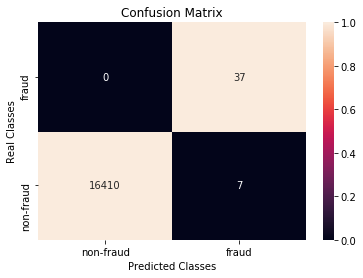

In [41]:
plot_confusion_matrix(y_test, smote_preds)

In [42]:
print(classification_report(
    y_test, smote_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     16417
       fraud       0.84      1.00      0.91        37

    accuracy                           1.00     16454
   macro avg       0.92      1.00      0.96     16454
weighted avg       1.00      1.00      1.00     16454



Due to the randomness of XGBoost your results may vary, but overall, you should see a large increase in non-fraud cases being classified as fraud (false positives). The reason this happens is because SMOTE has oversampled the fraud class so much that it's increased its overlap in feature space with the non-fraud cases.
Since Cohen's Kappa gives more weight to false positives than balanced accuracy does, the metric drops significantly, as does the precision and F1 score for fraud cases. However, we can bring a balance between the metrics again by adjusting our classification threshold.

So far we've been using 0.5 as the threshold between labeling a point as fraud or not. We can try different thresholds to see if they affect the result of the classification. To evaluate we'll use the balanced accuracy and Cohen's Kappa metrics.

In [43]:
for thres in np.linspace(0.1, 0.9, num=9):
    smote_thres_preds = np.where(smote_raw_preds > thres, 1, 0)
    print("Threshold: {:.1f}".format(thres))
    print("Balanced accuracy = {:.3f}".format(balanced_accuracy_score(y_test, smote_thres_preds)))
    print("Cohen's Kappa = {:.3f}\n".format(cohen_kappa_score(y_test, smote_thres_preds)))

Threshold: 0.1
Balanced accuracy = 0.999
Cohen's Kappa = 0.621

Threshold: 0.2
Balanced accuracy = 0.999
Cohen's Kappa = 0.804

Threshold: 0.3
Balanced accuracy = 1.000
Cohen's Kappa = 0.840

Threshold: 0.4
Balanced accuracy = 1.000
Cohen's Kappa = 0.881

Threshold: 0.5
Balanced accuracy = 1.000
Cohen's Kappa = 0.913

Threshold: 0.6
Balanced accuracy = 1.000
Cohen's Kappa = 0.937

Threshold: 0.7
Balanced accuracy = 0.986
Cohen's Kappa = 0.923

Threshold: 0.8
Balanced accuracy = 0.973
Cohen's Kappa = 0.909

Threshold: 0.9
Balanced accuracy = 0.959
Cohen's Kappa = 0.919



We see that Cohen's Kappa keeps increasing along with the threshold, without a significant loss in balanced accuracy. This adds a useful knob to our model: We can keep a low threshold if we care more about not missing any fraudulent cases, or we can increase the threshold to try to minimize the number of false positives.

## Hyperparameter tuning with XGBoost (optional)


Now that we have prepared the dataset and trained our model, one thing to note is there are algorithm settings which are called "hyperparameters" that can dramtically affect the performance of the trained models. For example, XGBoost algorithm has dozens of hyperparameters and we need to pick the right values for those hyperparameters in order to achieve the desired model training results. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.


Now we configure the hyperparameter tuning job by using the SDK that specifies following information:
* The Estimator to use for HPO. This we created in the earlier step for training.
* The ranges of hyperparameters we want to tune
* Number of training jobs to run in total and how many training jobs should be run simultaneously. More parallel jobs will finish tuning sooner, but may sacrifice accuracy. We recommend you set the parallel jobs value to less than 10% of the total number of training jobs (we'll set it higher just for this example to keep it short).
* The objective metric that will be used to evaluate training results, in this example, we select *validation:auc* to be the objective metric and the goal is to maximize the value throughout the hyperparameter tuning process. One thing to note is the objective metric has to be among the metrics that are emitted by the algorithm during training. In this example, the built-in XGBoost algorithm emits a bunch of metrics and *validation:auc* is one of them. If you bring your own algorithm to SageMaker, then you need to make sure whatever objective metric you select, your algorithm actually emits it.


We will tune three hyperparameters in this examples:
* *eta*: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative.  
* *min_child_weight*: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* *max_depth*: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 

In [44]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# Define hyperparameter ranges.
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: *validation:auc* and *train:auc*, and we elected to monitor *validation:auc* as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

In [45]:
objective_metric_name = "validation:auc"
objective_type = 'Maximize'

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The XGBoost estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [46]:
tuner = HyperparameterTuner(
    xgb, objective_metric_name, hyperparameter_ranges, max_jobs=2, max_parallel_jobs=2,objective_type=objective_type
)

In [47]:
tuner.fit({'train': s3_train_data,'validation':s3_train_data})

.................................................................!
